In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_train=pd.read_parquet("train.parquet",engine='pyarrow')
print(data_train.head())
data_test=pd.read_parquet("test.parquet",engine='pyarrow')
print(data_test.head())

                            Patient-Uid       Date           Incident
0  a0db1e73-1c7c-11ec-ae39-16262ee38c7f 2019-03-09  PRIMARY_DIAGNOSIS
1  a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f 2015-05-16  PRIMARY_DIAGNOSIS
3  a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f 2018-01-30     SYMPTOM_TYPE_0
4  a0dc950b-1c7c-11ec-b6ec-16262ee38c7f 2015-04-22        DRUG_TYPE_0
8  a0dc9543-1c7c-11ec-bb63-16262ee38c7f 2016-06-18        DRUG_TYPE_1
                            Patient-Uid       Date        Incident
0  a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f 2016-12-08  SYMPTOM_TYPE_0
1  a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f 2018-10-17     DRUG_TYPE_0
2  a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f 2017-12-01     DRUG_TYPE_2
3  a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f 2018-12-05     DRUG_TYPE_1
4  a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f 2017-11-04  SYMPTOM_TYPE_0


In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220868 entries, 0 to 29080911
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Patient-Uid  object        
 1   Date         datetime64[ns]
 2   Incident     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 98.3+ MB


In [4]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1065524 entries, 0 to 1372859
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Patient-Uid  1065524 non-null  object        
 1   Date         1065524 non-null  datetime64[ns]
 2   Incident     1065524 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 32.5+ MB


In [5]:
data_train['Patient-Uid'].shape , data_train['Date'].shape , data_train['Incident'].shape

((3220868,), (3220868,), (3220868,))

In [6]:
data_train.isna().sum()

Patient-Uid    0
Date           0
Incident       0
dtype: int64

In [7]:
data_train['Incident'].value_counts()

DRUG_TYPE_6          561934
DRUG_TYPE_1          484666
PRIMARY_DIAGNOSIS    431902
DRUG_TYPE_0          300005
DRUG_TYPE_7          258782
DRUG_TYPE_2          256841
DRUG_TYPE_8          160066
DRUG_TYPE_3          127676
TEST_TYPE_1           96810
TARGET DRUG           67218
DRUG_TYPE_9           66894
DRUG_TYPE_5           57510
DRUG_TYPE_11          48118
SYMPTOM_TYPE_0        46078
SYMPTOM_TYPE_6        32066
TEST_TYPE_0           27570
SYMPTOM_TYPE_7        22019
DRUG_TYPE_10          20925
DRUG_TYPE_14          17306
DRUG_TYPE_13          12372
DRUG_TYPE_12           9551
SYMPTOM_TYPE_14        8927
SYMPTOM_TYPE_1         8608
SYMPTOM_TYPE_2         8168
TEST_TYPE_3            8115
SYMPTOM_TYPE_5         7583
SYMPTOM_TYPE_8         7430
TEST_TYPE_2            7021
SYMPTOM_TYPE_15        6295
SYMPTOM_TYPE_10        6005
SYMPTOM_TYPE_29        5950
SYMPTOM_TYPE_16        4940
DRUG_TYPE_15           4906
SYMPTOM_TYPE_9         4885
DRUG_TYPE_4            4566
SYMPTOM_TYPE_4      

In [8]:
(data_train['Incident']=='TARGET DRUG').value_counts()

False    3153650
True       67218
Name: Incident, dtype: int64

In [9]:
data_train[(data_train['Incident']=='TARGET DRUG')]

,Patient-Uid,Date,Incident
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG
...,...,...,...
29074998,a0ef2b6d-1c7c-11ec-9172-16262ee38c7f,2018-10-12,TARGET DRUG
29075105,a0ebe423-1c7c-11ec-a5e0-16262ee38c7f,2019-07-02,TARGET DRUG
29075494,a0ebc713-1c7c-11ec-bd53-16262ee38c7f,2019-05-21,TARGET DRUG
29080031,a0ee1bdb-1c7c-11ec-90ba-16262ee38c7f,2018-06-07,TARGET DRUG


In [10]:
def output(col):
    Incident=col
    if Incident=='TARGET DRUG':
        return '1'
    else:
        return '0'

In [11]:
data_train['output']=data_train['Incident'].apply(output)

In [12]:
data_train['output'].value_counts()

0    3153650
1      67218
Name: output, dtype: int64

In [13]:
oe=OrdinalEncoder()
cols=['Patient-Uid','Date','Incident']
data_train[cols]=oe.fit_transform(data_train[cols])
data_test[cols]=oe.fit_transform(data_test[cols])

In [14]:
x=data_train.iloc[:,:-1]
print(x.head())
y=data_train.iloc[:,-1]
print(y.head())

   Patient-Uid    Date  Incident
0          0.0  1432.0      19.0
1          1.0    39.0      19.0
3          2.0  1029.0      20.0
4          3.0    15.0       0.0
8          4.0   438.0       1.0
0    0
1    0
3    0
4    0
8    0
Name: output, dtype: object


In [15]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [16]:
y.info()

<class 'pandas.core.series.Series'>
Int64Index: 3220868 entries, 0 to 29080911
Series name: output
Non-Null Count    Dtype 
--------------    ----- 
3220868 non-null  object
dtypes: object(1)
memory usage: 49.1+ MB


In [17]:
ytrain.value_counts() , ytest.value_counts()

(0    2207554
 1      47053
 Name: output, dtype: int64,
 0    946096
 1     20165
 Name: output, dtype: int64)

In [18]:
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
ytest=le.fit_transform(ytest)

In [19]:
xgb=XGBClassifier()

xgb.fit(xtrain,ytrain)
ypred_xgb=xgb.predict(xtest)

train=xgb.score(xtrain,ytrain)
test=xgb.score(xtest,ytest)
print(f'Train:{train}\nTest:{test}\n')
print(classification_report(ytest,ypred_xgb))

Train:1.0
Test:1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    946096
           1       1.00      1.00      1.00     20165

    accuracy                           1.00    966261
   macro avg       1.00      1.00      1.00    966261
weighted avg       1.00      1.00      1.00    966261



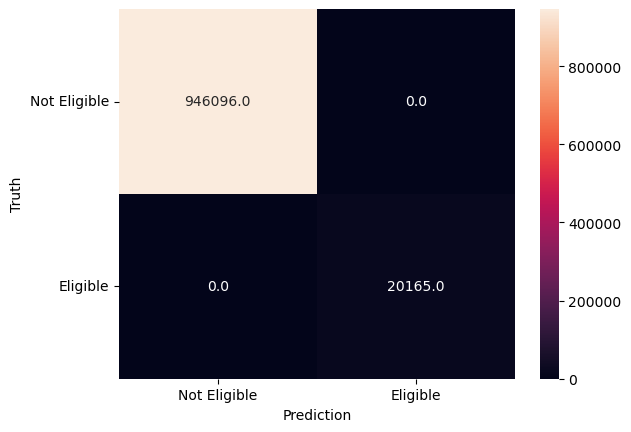

In [20]:
cm_xgb=confusion_matrix(ytest,ypred_xgb)
sns.heatmap(cm_xgb,annot=True,fmt=".1f",xticklabels=['Not Eligible','Eligible'],yticklabels=['Not Eligible','Eligible'])
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.yticks(rotation=0)
plt.show();

In [21]:
X_test=data_test

In [22]:
xgb.fit(xtrain,ytrain)
pred=xgb.predict(X_test)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
Patient_Uid=pd.read_parquet("test.parquet",engine='pyarrow')
Patient_Uid=Patient_Uid.iloc[:,:1]

In [24]:
predect=list(pred)
patient_uid=Patient_Uid['Patient-Uid'].tolist()

In [25]:
Submission=pd.DataFrame({'Patient_Uid':patient_uid,'output':predect})

In [26]:
Submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065524 entries, 0 to 1065523
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   Patient_Uid  1065524 non-null  object
 1   output       1065524 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 12.2+ MB


In [27]:
Submission.to_csv('final_submission.csv',index=False)